In [ ]:
!pip install keras
!pip install tensorflow

In [3]:
import os
import sklearn
import sklearn.datasets
import sklearn.ensemble
import xgboost
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

from omnixai.data.tabular import Tabular
import sys  
sys.path.insert(0, '../src/')
import matplotlib.pyplot as plt

import featureExtraction as fe

import evaluate as ev


WINDOW_SIZE = 256
OVERLAP_FACTOR = 0.5

fe_dataset = fe.FeatureExtractor('ours', WINDOW_SIZE, OVERLAP_FACTOR)
fe_dataset.extract_features()
fe_dataset.standarization()

Loading processed dataset with Window_size=256, Overlap=0.5 and name=ours...
Please wait, this loading could last some minutes...
../data/Window256Overlap0.5/labels.txt - loaded succesfully
../data/Window256Overlap0.5/users.txt - loaded succesfully
../data/Window256Overlap0.5/train.txt - loaded succesfully
../data/Window256Overlap0.5/val.txt - loaded succesfully
../data/Window256Overlap0.5/test.txt - loaded succesfully
../data/Window256Overlap0.5/sensors(128256, 256, 9).txt - loaded succesfully
Extracting features...


100%|██████████| 128256/128256 [00:44<00:00, 2911.55it/s]


Resultant features shape: (128256, 99)
Applying z-score normalization...
Done.


In [4]:
def column_names():
    names = []
    for sensor in ["acc","mag","gyro"]:
        for axis in ["x","y","z"]:
            for feature in ["mean","median","stds","vars","mins","max","mean-crossings","mean-mags","energy","entropy","zero-crossing"]:
                names.append(sensor+"_"+axis+"_"+feature)
    return names

feature_names = column_names()
df = pd.DataFrame(fe_dataset.features,columns = feature_names)
df.insert(len(feature_names), "label", fe_dataset.labels, True)
#df = df.drop(["mag_y_stds"],axis=1)
pd.set_option('display.max_columns', None)
df

,acc_x_mean,acc_x_median,acc_x_stds,acc_x_vars,acc_x_mins,acc_x_max,acc_x_mean-crossings,acc_x_mean-mags,acc_x_energy,acc_x_entropy,acc_x_zero-crossing,acc_y_mean,acc_y_median,acc_y_stds,acc_y_vars,acc_y_mins,acc_y_max,acc_y_mean-crossings,acc_y_mean-mags,acc_y_energy,acc_y_entropy,acc_y_zero-crossing,acc_z_mean,acc_z_median,acc_z_stds,acc_z_vars,acc_z_mins,acc_z_max,acc_z_mean-crossings,acc_z_mean-mags,acc_z_energy,acc_z_entropy,acc_z_zero-crossing,mag_x_mean,mag_x_median,mag_x_stds,mag_x_vars,mag_x_mins,mag_x_max,mag_x_mean-crossings,mag_x_mean-mags,mag_x_energy,mag_x_entropy,mag_x_zero-crossing,mag_y_mean,mag_y_median,mag_y_stds,mag_y_vars,mag_y_mins,mag_y_max,mag_y_mean-crossings,mag_y_mean-mags,mag_y_energy,mag_y_entropy,mag_y_zero-crossing,mag_z_mean,mag_z_median,mag_z_stds,mag_z_vars,mag_z_mins,mag_z_max,mag_z_mean-crossings,mag_z_mean-mags,mag_z_energy,mag_z_entropy,mag_z_zero-crossing,gyro_x_mean,gyro_x_median,gyro_x_stds,gyro_x_vars,gyro_x_mins,gyro_x_max,gyro_x_mean-crossings,gyro_x_mean-mags,gyro_x_energy,gyro_x_entropy,gyro_x_zero-crossing,gyro_y_mean,gyro_y_median,gyro_y_stds,gyro_y_vars,gyro_y_mins,gyro_y_max,gyro_y_mean-crossings,gyro_y_mean-mags,gyro_y_energy,gyro_y_entropy,gyro_y_zero-crossing,gyro_z_mean,gyro_z_median,gyro_z_stds,gyro_z_vars,gyro_z_mins,gyro_z_max,gyro_z_mean-crossings,gyro_z_mean-mags,gyro_z_energy,gyro_z_entropy,gyro_z_zero-crossing,label
0,-0.229089,-0.210813,-0.142095,-0.169778,0.161479,-0.067072,0.099355,-0.016687,-0.160851,0.139399,0.715358,0.035420,-0.006893,-0.113804,-0.180245,0.149726,-0.109364,-0.119610,0.042364,-0.193747,0.121470,1.229801,-0.213581,-0.199532,-0.157737,-0.220642,0.173928,0.002391,0.434929,-0.028845,-0.254000,0.173406,0.810872,-0.447037,-0.424851,-0.098214,-0.029978,-0.469169,-0.472195,-0.519765,-0.072627,-0.072802,0.155679,-0.195707,-0.955257,-0.951171,-0.419924,-0.038924,-0.841586,-1.024883,-0.112117,0.233766,0.034075,-0.288856,-0.188283,0.255607,0.256807,-0.255260,-0.015643,0.283165,0.218456,0.155994,-0.172059,-0.066023,0.155281,-0.215915,0.131219,0.057304,-0.418052,-0.253547,0.410370,-0.412545,0.058526,-0.382266,-0.254600,0.381405,1.118832,0.414972,0.333071,-0.344903,-0.250355,0.309315,-0.283266,0.183534,-0.257379,-0.250797,0.326701,0.624669,0.417784,0.281940,-0.340308,-0.219404,0.328538,-0.147062,0.025723,-0.256594,-0.222604,0.329783,0.351060,Car
1,-0.449031,-0.468804,-0.014357,-0.154181,-0.027015,-0.067072,-0.348801,0.048828,-0.144488,0.071237,-0.393571,-0.342446,-0.424078,-0.107713,-0.179508,0.084463,-0.106051,0.057560,0.062727,-0.189200,0.102919,0.367019,0.185760,0.300040,-0.157858,-0.220663,0.173928,0.002391,0.260832,0.001308,-0.245442,0.142167,0.339689,-0.589387,-0.578408,0.377611,-0.012052,-0.742838,-0.509967,-1.381580,0.433694,-0.054954,-0.188078,-0.195707,-0.954829,-0.951231,-0.397158,-0.038730,-0.852664,-1.001187,0.011063,0.263072,0.033911,-0.300555,-0.188283,0.260587,0.261143,-0.242281,-0.015576,0.286101,0.229923,-0.191292,-0.160887,-0.065868,0.149315,-0.215915,0.145086,0.039324,-0.395602,-0.252738,0.410370,-0.404816,0.085953,-0.361083,-0.253789,0.373920,0.344496,1.355375,0.982920,-0.202130,-0.237638,0.309315,-0.148039,0.289409,-0.154801,-0.224478,0.247708,-0.122232,0.964658,0.810218,-0.244198,-0.212682,0.328538,-0.147062,0.325828,-0.176214,-0.207883,0.272687,-0.055147,Car
2,-0.453679,-0.455101,-0.003846,-0.152677,-0.027015,-0.175697,0.016201,-0.056141,-0.143184,0.132513,-0.880417,-0.155425,-0.225465,-0.105394,-0.179224,0.084463,-0.106051,-0.271967,0.083382,-0.191598,0.097489,0.798410,0.051338,0.054539,-0.199500,-0.227639,0.158015,-0.148985,-0.230025,-0.106272,-0.256668,0.216930,0.470573,-0.851140,-0.874507,0.860623,0.018785,-0.957103,-0.664055,-1.516798,0.788497,-0.011915,-0.533497,-0.195707,-0.900627,-0.914633,-0.081956,-0.032806,-0.852664,-0.883776,0.388469,0.348983,0.011654,-0.324167,-0.188283,0.216244,0.226153,0.157139,-0.011302,0.202405,0.229923,-0.614351,-0.089184,-0.066985,0.130239,-0.215915,0.306697,0.170024,-0.398873,-0.252869,0.451804,-0.39

In [5]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.utils import to_categorical

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(fe_dataset.labels.copy())

# Check the order of classes
print("Classes:",label_encoder.classes_)
labels = to_categorical(labels)

train =fe_dataset.features[fe_dataset.idx_train]
train_labels =labels[fe_dataset.idx_train]
test =fe_dataset.features[fe_dataset.idx_test]
test_labels =labels[fe_dataset.idx_test]

Classes: ['Bike' 'Bus' 'Car' 'Metro' 'Moto' 'Run' 'Stationary' 'Train' 'Tram'
 'Walk' 'e-Bicing' 'e-Scooter']


In [6]:
model = xgboost.XGBClassifier(n_estimators=300, max_depth=5)
model.fit(train, train_labels)
print('Test accuracy: {}'.format(
    sklearn.metrics.accuracy_score(test_labels, model.predict(test))))

Test accuracy: 0.7151174880432523


In [7]:
y_pred = model.predict(test)
print(classification_report(y_pred, test_labels))

              precision    recall  f1-score   support

           0       0.54      0.62      0.58        24
           1       0.81      0.76      0.78      4356
           2       0.60      0.95      0.74      2529
           3       0.92      0.90      0.91      3901
           4       0.03      0.45      0.05        11
           5       0.98      0.99      0.99       487
           6       0.16      0.76      0.26       217
           7       0.27      0.74      0.39       250
           8       0.80      0.75      0.77      2323
           9       0.84      0.96      0.89      1932
          10       0.44      0.92      0.59        24
          11       0.73      0.85      0.79       428

   micro avg       0.73      0.85      0.79     16482
   macro avg       0.59      0.80      0.65     16482
weighted avg       0.79      0.85      0.81     16482
 samples avg       0.73      0.72      0.73     16482



c:\Users\miquel\Desktop\TFG\.conda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


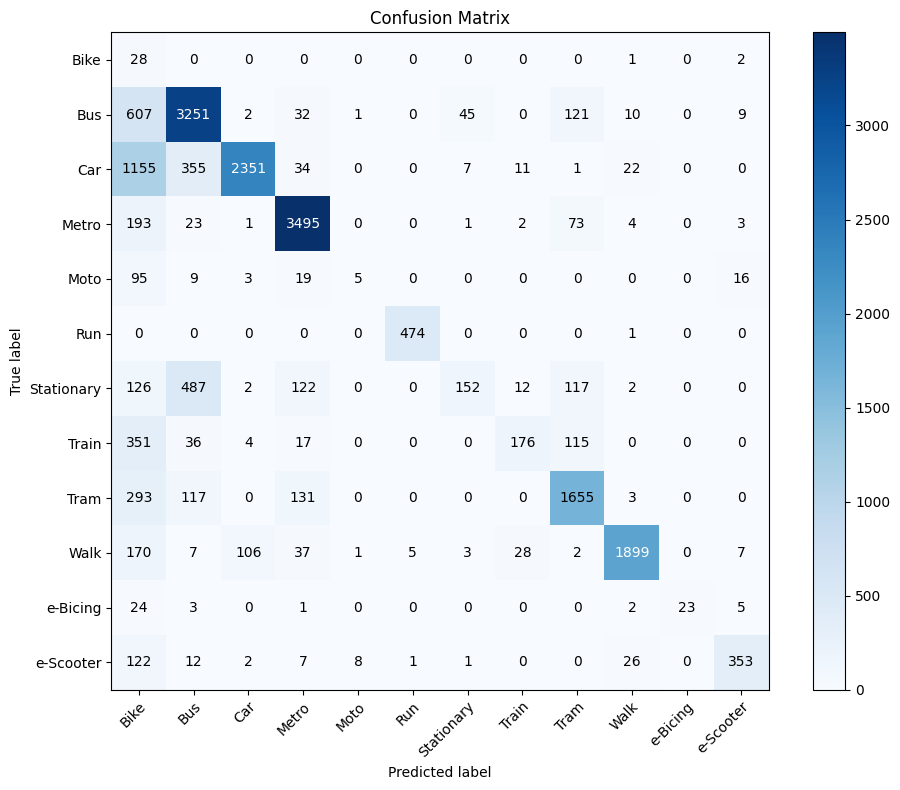

In [8]:
y_pred = model.predict(fe_dataset.features[fe_dataset.idx_val])
y_pred = np.argmax(y_pred, axis=1)
y_pred = label_encoder.inverse_transform(y_pred)


ev.plot_confusion_matrix(fe_dataset.labels[fe_dataset.idx_val], y_pred)